In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, f1_score, precision_score, roc_auc_score,
    confusion_matrix
)
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

# Global reproducibility seed
RANDOM_STATE = 42

# Plot style (for heatmaps etc.)
sns.set(style="whitegrid", font_scale=1.1)

In [2]:
# ============================================================
# 1. Load raw dataset, encode categorical features, split data
# ============================================================

# Read the final analysis dataset.
# Assumption:
# - 'COPD' is the binary target label (0 = non-COPD, 1 = COPD)
# - 'ID' is a subject identifier and must NOT be used as a feature
df = pd.read_csv("/Users/hwangsia/final_data.csv")

print("Original shape:", df.shape)
print(df.head())

# Separate target and drop ID from features
y = df["COPD"]
X_raw = df.drop(columns=["COPD", "ID"])

# One-hot encode all categorical features into numeric dummy indicators.
# drop_first=True drops one reference level per categorical variable
# to reduce perfect multicollinearity.
X_encoded = pd.get_dummies(X_raw, drop_first=True)

print("After one-hot encoding shape:", X_encoded.shape)
print(X_encoded.head())

# Train/test split BEFORE any scaling or oversampling.
# We keep a held-out test set for final evaluation.
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train COPD distribution:\n", y_train.value_counts())
print("Test COPD distribution:\n", y_test.value_counts())



Original shape: (2776, 11)
                ID  COPD  age     sex OccupationRisk Income         smoking  \
0  CODA24L27862226     0  50s    Male    Non–at-risk   High   Former Smoker   
1  CODA24L31534447     0  50s    Male        At-risk   High  Current Smoker   
2  CODA24L47263638     0  50s    Male    Non–at-risk    Low      Non-smoker   
3  CODA24L14080640     0  50s  Female    Non–at-risk   High      Non-smoker   
4  CODA24L76507177     1  50s    Male    Non–at-risk   High   Former Smoker   

  Packyears Asthma BMI_Group PM25_Group  
0       low     No     Obese       high  
1       low     No    Normal        low  
2       NaN     No     Obese       high  
3       NaN     No    Normal       high  
4       low     No    Normal        low  
After one-hot encoding shape: (2776, 11)
   age_60s  age_70+  sex_Male  OccupationRisk_Non–at-risk  Income_Low  \
0    False    False      True                        True       False   
1    False    False      True                       False  

In [3]:
# =====================================================================
# 2. Stratified 10-fold cross-validation grid search over ADASYN params
#    - r (sampling_strategy): how aggressively we oversample the minority
#    - k (n_neighbors): neighbor count used to synthesize minority points
#
#    For each (r, k) pair:
#      * Within each CV fold:
#         - fit scaler on train fold only
#         - oversample train fold with ADASYN
#         - train logistic regression
#         - evaluate on validation fold WITHOUT oversampling
#      * Record mean/std of Recall and F1 across folds
#
#    Output:
#      - grid_df (full table like "Appendix 2")
#      - grid_top (top-performing rows like "Table 3")
# =====================================================================

# Define the ADASYN hyperparameter grid.
# r controls the minority:majority balancing ratio; higher r ~ more aggressive oversampling.
# k controls local neighborhood size in ADASYN's synthetic sample generation.
r_values = [round(v, 2) for v in np.arange(0.20, 1.01, 0.10)]  # e.g. 0.20, 0.30, ..., 1.00
k_values = [3, 5, 7, 9, 11, 13, 15]

# StratifiedKFold preserves the class ratio in each fold,
# which is important for imbalanced classification problems.
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

grid_records = []  # will collect per-(r,k) CV performance summary

for r in r_values:
    for k in k_values:

        fold_recalls = []
        fold_f1s = []

        # Perform Stratified 10-fold CV on the training set only.
        for train_idx, val_idx in cv.split(X_train, y_train):
            # Split fold into train/val subsets
            X_tr_fold = X_train.iloc[train_idx].copy()
            y_tr_fold = y_train.iloc[train_idx].copy()
            X_val_fold = X_train.iloc[val_idx].copy()
            y_val_fold = y_train.iloc[val_idx].copy()

            # 1) Fit the scaler ONLY on the fold's train portion
            scaler = StandardScaler()
            X_tr_fold_scaled = scaler.fit_transform(X_tr_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            # 2) Apply ADASYN ONLY on the fold's train portion
            #    This simulates oversampling inside the training pipeline,
            #    avoiding any leakage into the validation fold.
            ada = ADASYN(
                sampling_strategy=r,
                n_neighbors=k,
                random_state=RANDOM_STATE
            )
            X_tr_fold_res, y_tr_fold_res = ada.fit_resample(X_tr_fold_scaled, y_tr_fold)

            # 3) Train a simple baseline classifier (logistic regression)
            #    on the resampled training fold.
            clf = LogisticRegression(
                random_state=RANDOM_STATE,
                max_iter=1000
            )
            clf.fit(X_tr_fold_res, y_tr_fold_res)

            # 4) Evaluate on the untouched validation fold
            #    using the same scaler.transform() but NO oversampling.
            y_val_pred = clf.predict(X_val_fold_scaled)

            # 5) Collect fold-level metrics at decision threshold 0.5
            fold_recalls.append(recall_score(y_val_fold, y_val_pred))
            fold_f1s.append(f1_score(y_val_fold, y_val_pred))

        # After all folds, aggregate mean and std of metrics
        mean_recall = float(np.mean(fold_recalls))
        std_recall = float(np.std(fold_recalls, ddof=1))
        mean_f1 = float(np.mean(fold_f1s))
        std_f1 = float(np.std(fold_f1s, ddof=1))

        grid_records.append({
            "r": r,
            "k": k,
            "mean_recall": round(mean_recall, 4),
            "std_recall": round(std_recall, 4),
            "mean_f1": round(mean_f1, 4),
            "std_f1": round(std_f1, 4)
        })

# Build full grid results DataFrame (Appendix-style table)
grid_df = pd.DataFrame(grid_records)

# Create a "top combinations" table similar to a main text table.
# Sort primarily by mean_recall (descending),
# then by std_recall (ascending) to prefer more stable combos.
grid_top = (
    grid_df
    .sort_values(by=["mean_recall", "std_recall"], ascending=[False, True])
    .head(5)
)

print("=== Full Grid Search results (preview) ===")
print(grid_df.head())
print("\n=== Top-performing ADASYN settings (for main text table) ===")
print(grid_top)

# Save full and top tables for record / manuscript appendix
grid_df.to_csv("/Users/hwangsia/ADASYN_grid_full.csv", index=False)
grid_top.to_csv("/Users/hwangsia/ADASYN_grid_top.csv", index=False)



=== Full Grid Search results (preview) ===
     r   k  mean_recall  std_recall  mean_f1  std_f1
0  0.2   3       0.0622      0.0491   0.1090  0.0835
1  0.2   5       0.0438      0.0333   0.0808  0.0602
2  0.2   7       0.0475      0.0348   0.0874  0.0621
3  0.2   9       0.0365      0.0243   0.0683  0.0445
4  0.2  11       0.0438      0.0336   0.0799  0.0598

=== Top-performing ADASYN settings (for main text table) ===
      r   k  mean_recall  std_recall  mean_f1  std_f1
61  1.0  13       0.6827      0.0652   0.3184  0.0197
62  1.0  15       0.6791      0.0688   0.3192  0.0278
58  1.0   7       0.6790      0.0672   0.3202  0.0257
56  1.0   3       0.6755      0.0718   0.3203  0.0254
57  1.0   5       0.6721      0.0694   0.3209  0.0281


In [4]:
# =============================================================================
# 3. Pick the best (r, k) based on mean_recall (highest sensitivity)
#    Then:
#      - Fit scaler on the entire training set (X_train)
#      - Oversample the entire training set with ADASYN(best_r, best_k)
#      - Summarize class distribution before/after
#
#    Output:
#      - table4_df : class balance table (like "Table 4")
# =============================================================================

# Select best combo by highest mean_recall
best_row = grid_df.sort_values(by="mean_recall", ascending=False).iloc[0]
best_r = float(best_row["r"])
best_k = int(best_row["k"])

print("Chosen best ADASYN hyperparameters (r, k):", best_r, best_k)

# Fit scaler on the entire training data (NOT including test data).
scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train)

# Oversample the scaled training data using the chosen ADASYN config.
ada_best = ADASYN(
    sampling_strategy=best_r,
    n_neighbors=best_k,
    random_state=RANDOM_STATE
)
X_train_aug, y_train_aug = ada_best.fit_resample(X_train_scaled_full, y_train)

# Summarize class distribution before and after oversampling
orig_counts = y_train.value_counts().sort_index()  # 0 then 1
aug_counts = pd.Series(y_train_aug).value_counts().sort_index()

orig_ratio = round(orig_counts[0] / orig_counts[1], 2)
aug_ratio = round(aug_counts[0] / aug_counts[1], 2)

table4_df = pd.DataFrame({
    "Dataset": ["Original Train", f"ADASYN (r={best_r}, k={best_k})"],
    "Neg(0)": [int(orig_counts[0]), int(aug_counts[0])],
    "Pos(1)": [int(orig_counts[1]), int(aug_counts[1])],
    "Ratio":  [
        f"{orig_counts[0]} : {orig_counts[1]} ({orig_ratio}:1)",
        f"{aug_counts[0]} : {aug_counts[1]} ({aug_ratio}:1)"
    ]
})

print("\n=== Table 4: Class distribution before vs. after ADASYN ===")
print(table4_df)

# Save class balance summary
table4_df.to_csv("/Users/hwangsia/ADASYN_table4_class_balance.csv", index=False)



Chosen best ADASYN hyperparameters (r, k): 1.0 13

=== Table 4: Class distribution before vs. after ADASYN ===
                Dataset  Neg(0)  Pos(1)                Ratio
0        Original Train    1946     274   1946 : 274 (7.1:1)
1  ADASYN (r=1.0, k=13)    1946    1950  1946 : 1950 (1.0:1)


In [5]:
# =============================================================================
# 4. Train final logistic regression models:
#    (A) Original imbalanced training data
#    (B) ADASYN-augmented training data
#
#    Evaluate both on the same untouched test set.
#    Metrics are computed at threshold 0.5 for predicted probability.
#
#    Output:
#      - table5_df : performance comparison table (like "Table 5")
# =============================================================================

# Scale the held-out test set using the scaler fitted on the original train set
# (the same scaler_full we trained above). We do NOT oversample the test set.
X_test_scaled_full = scaler_full.transform(X_test)

# (A) Baseline model trained on original training data
clf_orig = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
clf_orig.fit(X_train_scaled_full, y_train)

y_pred_orig = clf_orig.predict(X_test_scaled_full)  # implicit threshold 0.5
y_prob_orig = clf_orig.predict_proba(X_test_scaled_full)[:, 1]

orig_f1 = f1_score(y_test, y_pred_orig)
orig_rec = recall_score(y_test, y_pred_orig)
orig_prec = precision_score(y_test, y_pred_orig, zero_division=0)
orig_auc = roc_auc_score(y_test, y_prob_orig)

# (B) Model trained on ADASYN-augmented data
clf_aug = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
clf_aug.fit(X_train_aug, y_train_aug)

y_pred_aug = clf_aug.predict(X_test_scaled_full)  # implicit threshold 0.5
y_prob_aug = clf_aug.predict_proba(X_test_scaled_full)[:, 1]

aug_f1 = f1_score(y_test, y_pred_aug)
aug_rec = recall_score(y_test, y_pred_aug)
aug_prec = precision_score(y_test, y_pred_aug, zero_division=0)
aug_auc = roc_auc_score(y_test, y_prob_aug)

table5_df = pd.DataFrame({
    "Training Dataset": ["Original Train", "ADASYN Augmented Train"],
    "F1 Score":  [round(orig_f1, 4), round(aug_f1, 4)],
    "Recall":    [round(orig_rec, 4), round(aug_rec, 4)],
    "Precision": [round(orig_prec, 4), round(aug_prec, 4)],
    "AUC-ROC":   [round(orig_auc, 4), round(aug_auc, 4)]
})

print("\n=== Table 5: Performance comparison (original vs ADASYN) ===")
print(table5_df)

# Save performance comparison summary
table5_df.to_csv("/Users/hwangsia/ADASYN_table5_performance.csv", index=False)


=== Table 5: Performance comparison (original vs ADASYN) ===
         Training Dataset  F1 Score  Recall  Precision  AUC-ROC
0          Original Train    0.0548  0.0294     0.4000   0.7194
1  ADASYN Augmented Train    0.3243  0.6176     0.2199   0.7163


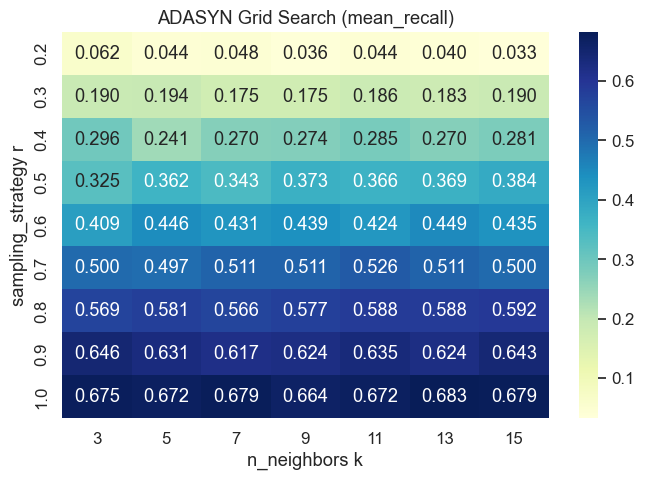

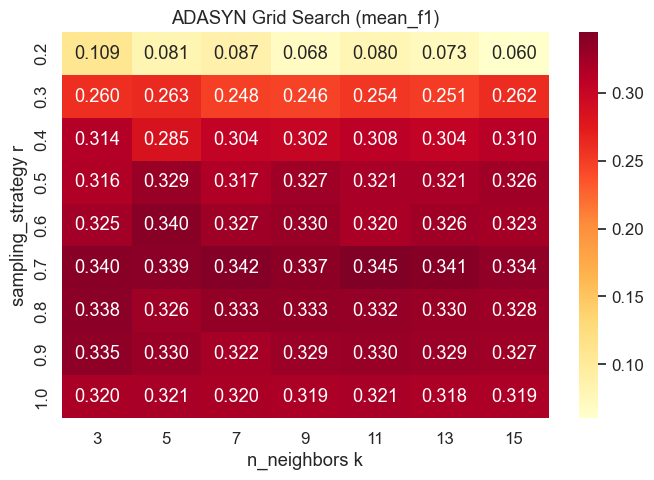

In [6]:
# =============================================================================
# 5. Visualization of the ADASYN grid search
#    We produce heatmaps of mean_recall and mean_f1
#    across (r, k) pairs. These correspond to "sensitivity maps"
#    of how oversampling ratio and neighborhood size affect model quality.
#
#    Output:
#      - ADASYN_heatmap_mean_recall.png
#      - ADASYN_heatmap_mean_f1.png
# =============================================================================

# Pivot tables for plotting:
# rows  -> r (sampling_strategy)
# cols  -> k (n_neighbors)
# cells -> mean metric
pivot_recall = grid_df.pivot_table(index="r", columns="k", values="mean_recall")
pivot_f1 = grid_df.pivot_table(index="r", columns="k", values="mean_f1")

# Heatmap: mean_recall
plt.figure(figsize=(7,5))
sns.heatmap(pivot_recall, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("ADASYN Grid Search (mean_recall)")
plt.ylabel("sampling_strategy r")
plt.xlabel("n_neighbors k")
plt.tight_layout()
plt.savefig("/Users/hwangsia/ADASYN_heatmap_mean_recall.png", dpi=300)
plt.show()

# Heatmap: mean_f1
plt.figure(figsize=(7,5))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("ADASYN Grid Search (mean_f1)")
plt.ylabel("sampling_strategy r")
plt.xlabel("n_neighbors k")
plt.tight_layout()
plt.savefig("/Users/hwangsia/ADASYN_heatmap_mean_f1.png", dpi=300)
plt.show()


In [8]:
# =============================================================================
# 6. Export ADASYN-augmented training data (decoded version for BN)
#
# We now export the fully oversampled training data after decoding
# the one-hot encoded categorical columns back to their original
# category labels (manual decoding, since we used pd.get_dummies()).
#
# Output:
#   /Users/hwangsia/adasyn_data_decoded.csv
# =============================================================================

import pandas as pd
import numpy as np
import re

# Combine oversampled features + target into a single DataFrame
adasyn_aug_df = pd.DataFrame(X_train_aug, columns=X_train.columns)
adasyn_aug_df["COPD"] = y_train_aug.values

print("\nADASYN-augmented (numeric) shape:", adasyn_aug_df.shape)

# -------------------------------------------------------------------------
# 1️⃣ Identify which columns came from which categorical variable
# -------------------------------------------------------------------------
cat_groups = {}
for col in X_train.columns:
    if "_" in col:
        prefix = col.split("_")[0]
        cat_groups.setdefault(prefix, []).append(col)

# -------------------------------------------------------------------------
# 2️⃣ For each categorical group, pick the column with max value as category
# -------------------------------------------------------------------------
decoded_df = pd.DataFrame(index=adasyn_aug_df.index)

for prefix, cols in cat_groups.items():
    slice_ = adasyn_aug_df[cols].values
    max_idx = np.argmax(slice_, axis=1)
    decoded_values = [cols[i].split("_", 1)[1] for i in max_idx]
    decoded_df[prefix] = decoded_values

# -------------------------------------------------------------------------
# 3️⃣ Add back any numeric (non-dummy) columns
# -------------------------------------------------------------------------
# drop columns used in get_dummies
dummy_cols = [c for group in cat_groups.values() for c in group]
numeric_cols = [c for c in X_train.columns if c not in dummy_cols]
if numeric_cols:
    decoded_df[numeric_cols] = adasyn_aug_df[numeric_cols].values

# -------------------------------------------------------------------------
# 4️⃣ Add target column
# -------------------------------------------------------------------------
decoded_df["COPD"] = y_train_aug.values

# -------------------------------------------------------------------------
# 5️⃣ Save decoded categorical version
# -------------------------------------------------------------------------
decoded_df.to_csv("/Users/hwangsia/adasyn_data_decoded.csv", index=False)

print("\nDecoded categorical version shape:", decoded_df.shape)
print("Decoded sample:\n", decoded_df.head())
print("\nSaved categorical BN-ready file: adasyn_data_decoded.csv")



ADASYN-augmented (numeric) shape: (3896, 12)

Decoded categorical version shape: (3896, 10)
Decoded sample:
    age   sex OccupationRisk Income        smoking Packyears Asthma  \
0  60s  Male    Non–at-risk    Low  Former Smoker       low    Yes   
1  70+  Male    Non–at-risk    Low  Former Smoker       low    Yes   
2  60s  Male    Non–at-risk    Low  Former Smoker       low    Yes   
3  70+  Male    Non–at-risk    Low     Non-smoker       low    Yes   
4  70+  Male    Non–at-risk    Low     Non-smoker       low    Yes   

           BMI       PM25  COPD  
0  Group_Obese  Group_low     0  
1  Group_Obese  Group_low     0  
2  Group_Obese  Group_low     1  
3  Group_Obese  Group_low     0  
4  Group_Obese  Group_low     0  

Saved categorical BN-ready file: adasyn_data_decoded.csv
